# Quantum Teleportation Algorithm (Protocol)

Quantum teleportation protocol is a fundamental quantum communication protocol that transfers an arbitrary qubit state from one location (Alice) to another (Bob) using entanglement and classical communication.

The circuit begins by creating a Bell pair shared between Alice and Bob.
Alice then entangles her unknown qubit with her part of the Bell pair and performs measurements of the quibits at her side.
The measurement results are then transferd classicaly to bob in order to apply controlled corrections on Bob’s qubit, completing the teleportation process.

This example highlights the use of mid-circuit measurements in QMod, which are crucial for simulating hybrid quantum–classical behavior in quantum algorithms.

## Algorithm Description

The protocol starts with an arbitrary quantum state on **`alice_qubit`**, which we wish to teleport to Bob.
##### 1. Bell State Creation
- Apply a **Hadamard (`H`)** gate to **`bell_pair_qubit`**.  
- Apply a **CNOT** gate with **`bell_pair_qubit`** as control and **`bob_qubit`** as target.  
These two qubits now form a bell state.
##### 2. Entangling Alice’s Qubit with the Bell Pair
- Apply a **CNOT** gate from **`alice_qubit`** to **`bell_pair_qubit`**.  
- Apply a **Hadamard (`H`)** gate on **`alice_qubit`**.  
This step entangles Alice’s qubit with the Bell pair.
##### 3. Mid-Circuit Measurement
Measure **`alice_qubit`** and **`bell_pair_qubit`**.  
The measurement results are stored as classical bits and later used for conditional corrections.
##### 4. Classically Controlled Corrections
Depending on the measurement outcomes:  
- If **`bell_pair_qubit`** measures `1`, apply **`X`** on **`bob_qubit`**.  
- If **`alice_qubit`** measures `1`, apply **`Z`** on **`bob_qubit`**.  

These classically controlled gates complete the teleportation process, reconstructing the original quantum state on **`bob_qubit`**.

![quantum_teleportation_circuit.png](quantum_teleportation_circuit.png)
<center>
<figcaption align = "middle"> Figure 1. Quantum Teleportation algorithm </figcaption>
</center>

## How to Build the Algorithm with Classiq

mid circuit measurment!!!

We define a `quantum_teleportation` quantum function whose arguments are a 3 qubits, one for alice, one for bob and one for the mutual bell pair.

### classiq's implematation

In [28]:
from classiq import *
import numpy as np

@qfunc
def quantum_teleportation(alice_qubit: QBit, bob_qubit: QBit, bell_pair_qubit: QBit) -> None:
    
    # Step 1: Create Bell pair between bell_pair_qubit and Bob's qubit
    H(bell_pair_qubit)
    CX(bell_pair_qubit, bob_qubit)
    
    # Step 2: Alice performs Bell measurement on her qubits
    CX(alice_qubit, bell_pair_qubit)
    H(alice_qubit)
    
    # Step 3: Measure Alice's qubits to get classical bits
    alice_bit1 = measure(alice_qubit)
    alice_bit2 = measure(bell_pair_qubit)
    
    # Step 4: Apply corrections to Bob's qubit based on Alice's measurements
    if_(alice_bit2, lambda: X(bob_qubit))  # Apply X if bell_pair_qubit measurement is 1
    if_(alice_bit1, lambda: Z(bob_qubit))  # Apply Z if alice_qubit measurement is 1

In [29]:
@qfunc
def prepare_test_state(q: QBit) -> None:

    H(q)

In [27]:
@qfunc
def main(bob_qubit: Output[QBit]) -> None:

    alice_qubit = QBit()
    bell_pair_qubit = QBit()

    # Allocate qubits
    allocate(1, alice_qubit)
    allocate(1, bob_qubit)
    allocate(1, bell_pair_qubit)
    
    # Prepare the state to be teleported on Alice's qubit
    prepare_test_state(alice_qubit)
    
    # Perform teleportation
    quantum_teleportation(alice_qubit, bob_qubit, bell_pair_qubit)

In [30]:
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/34kKBgE8bffcHFUPYLppWE7E1sp


In [21]:
job = execute(qprog)
job.get_sample_result().dataframe

,bob_qubit,count,probability,bitstring
0,1,1092,0.533203,1
1,0,956,0.466797,0


### The Classical Postprocess

The classical part of the algorithm reads: The probability of measuring the $|0\rangle_n$ state is 1 if the function is constant and 0 if it is balanced. 
We define a classical function that gets the execution results from running the quantum part and returns whether the function is constant or balanced:

In [22]:
def post_process_deutsch_jozsa(parsed_results):
    if len(parsed_results) == 1:
        if 0 not in parsed_results:
            print("The function is balanced")
        else:
            print("The function is constant")
    else:
        print(
            "cannot decide as more than one output was measured, the distribution is:",
            parsed_results,
        )

## Example: Simple Arithmetic Oracle

We start with a simple example on $n=4$ qubits, and $f(x)= x >7$. Classically, in the worst case, the function should be evaluated $2^{n-1}+1=9$ times. However, with the Deutsch-Jozsa algorithm, this function is evaluated only once.

We build a predicate for this specific use case:

In [23]:
@qperm
def simple_predicate(x: Const[QNum], res: QBit) -> None:
    res ^= x > 7

Next, we define a model by inserting the predicate into the `deutsch_jozsa` function:

In [24]:
NUM_QUBITS = 4


@qfunc
def main(x: Output[QNum[NUM_QUBITS]]):
    allocate(x)
    deutsch_jozsa(lambda x, y: simple_predicate(x, y), x)


qmod_1 = create_model(main, out_file="simple_deutsch_jozsa")
qprog_1 = synthesize(qmod_1)

ClassiqExpansionError: 
	NameError: name 'deutsch_jozsa' is not defined
		at file 4292876506.py line 7 character 4 in function main
If you need further assistance, please reach out on our Community Slack channel at: https://short.classiq.io/join-slack or open a support ticket at: https://classiq-community.freshdesk.com/support/tickets/new

Finally, we execute and call the classical postprocess:

In [ ]:
result_1 = execute(qprog_1).result_value()
results_list_1 = [sample.state["x"] for sample in result_1.parsed_counts]
post_process_deutsch_jozsa(results_list_1)

The function is balanced


In [ ]:
show(qprog_1)

Quantum program link: https://platform.classiq.io/circuit/32pQaVYcsW0vT5ojnolMCmcbTnk


## Example: Complex Arithmetic Oracle

*Generalizing to more complex scenarios makes no difference for modeling*. Let us take a complicated function, working with $n=3$: a function $f(x)$ that first takes the maximum between the input bitwise-xor with 4 and the input bitwise-and with 3, then checks whether the result is greater or equal to 4. Can you tell whether the function is balanced or constant?

*This time we provide a width bound to the synthesis engine.*

We follow the three steps as before:

In [ ]:
from classiq.qmod.symbolic import max

NUM_QUBITS = 3


@qperm
def complex_predicate(x: Const[QNum], res: QBit) -> None:
    res ^= max(x ^ 4, x & 3) >= 4


@qfunc
def main(x: Output[QNum[NUM_QUBITS]]):
    allocate(x)
    deutsch_jozsa(lambda x, y: complex_predicate(x, y), x)


qmod_2 = create_model(
    main, constraints=Constraints(max_width=19), out_file="complex_deutsch_jozsa"
)
qprog_2 = synthesize(qmod_2)

result_2 = execute(qprog_2).result_value()
results_list_2 = [sample.state["x"] for sample in result_2.parsed_counts]
post_process_deutsch_jozsa(results_list_2)

The function is balanced


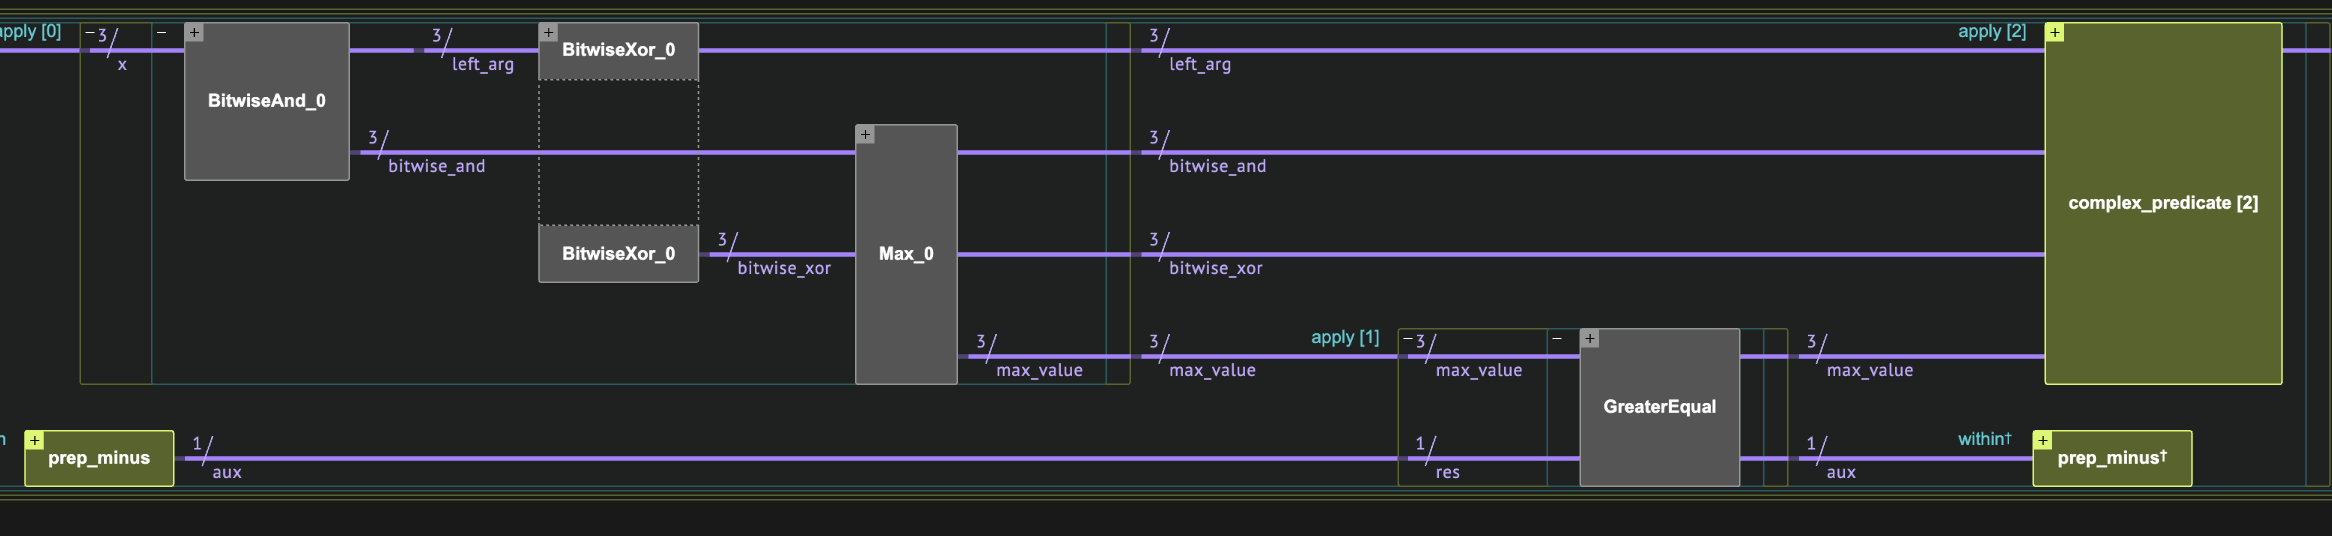
<center>
<figcaption align = "middle"> Figure 2. The Deutsch-Jozsa algorithm for the complex example, focusing on oracle implementation (the last block performs uncomputation). </figcaption>
</center>

We can visualize the circuit obtained from the synthesis engine. Figure 2 presents the complex structure of the oracle, generated automatically by the synthesis engine.

In [ ]:
show(qprog_2)

Quantum program link: https://platform.classiq.io/circuit/32pQc3Nspjzp6peDicCbgVkxhRB


## Technical Notes

Start with alice's qubit:
$$
\lvert a \rangle = \alpha \lvert 0 \rangle + \beta \lvert 1 \rangle 
$$

Bobs qubit and the bell pair start at state $\lvert b \rangle =  \lvert 0 \rangle$, $\lvert p \rangle =  \lvert 0 \rangle$

Create a bell state between $\lvert p \rangle$ and $\lvert b \rangle$
$$
\lvert \psi \rangle_{pb} = \tfrac{1}{\sqrt{2}}(\lvert 00 \rangle_{pb} + \lvert 11 \rangle_{pb})
$$
The total state is now:  
$$
\lvert \psi \rangle_{apb} = (\alpha \lvert 0 \rangle_{a} + \beta \lvert 1 \rangle_{a} )(\tfrac{1}{\sqrt{2}}(\lvert 00 \rangle_{pb} + \lvert 11 \rangle_{pb}))=\tfrac{\alpha}{\sqrt{2}}\lvert 000 \rangle_{apb}+\tfrac{\alpha}{\sqrt{2}}\lvert 011 \rangle_{apb}+\tfrac{\beta}{\sqrt{2}}\lvert 100 \rangle_{apb}+\tfrac{\beta}{\sqrt{2}}\lvert 111 \rangle_{apb}
$$
After applying CX(a,p):  
$$
\lvert \psi \rangle_{apb} = \tfrac{\alpha}{\sqrt{2}}\lvert 000 \rangle_{apb}+\tfrac{\alpha}{\sqrt{2}}\lvert 011 \rangle_{apb}+\tfrac{\beta}{\sqrt{2}}\lvert 110 \rangle_{apb}+\tfrac{\beta}{\sqrt{2}}\lvert 101 \rangle_{apb}
$$

Applying H(a):
$$
\lvert \psi \rangle_{apb} = \tfrac{\alpha}{2}\lvert 000 \rangle_{apb}+\tfrac{\alpha}{2}\lvert 100 \rangle_{apb}+\tfrac{\alpha}{2}\lvert 011 \rangle_{apb}+\tfrac{\alpha}{2}\lvert 111 \rangle_{apb}+\tfrac{\beta}{2}\lvert 010 \rangle_{apb}-\tfrac{\beta}{2}\lvert 110 \rangle_{apb}+\tfrac{\beta}{2}\lvert 001 \rangle_{apb}-\tfrac{\beta}{2}\lvert 101 \rangle_{apb}
$$
Simplify:
$$
\begin{split}
\lvert \psi \rangle_{apb} = \tfrac{1}{2} \big[ 
&\lvert 00 \rangle_{ap} \otimes (\alpha \lvert 0 \rangle_{b} + \beta \lvert 1 \rangle_{b}) \\
&+ \lvert 01 \rangle_{ap} \otimes (\alpha \lvert 1 \rangle_{b} + \beta \lvert 0 \rangle_{b}) \\
&+ \lvert 10 \rangle_{ap} \otimes (\alpha \lvert 0 \rangle_{b} - \beta \lvert 1 \rangle_{b}) \\
&+ \lvert 11 \rangle_{ap} \otimes (\alpha \lvert 1 \rangle_{b} - \beta \lvert 0 \rangle_{b}) 
\big]
\end{split}
$$
The classical correction operations based on Alice’s and the Bell-pair measurement results are:
$$
\begin{array}{ccl}
00 &\rightarrow& I(b) \\
01 &\rightarrow& X(b) \\
10 &\rightarrow& Z(b) \\
11 &\rightarrow& Z(b)X(b)
\end{array}
$$

## References

<a id='QTWiki'>[1]</a>: [Qunatum Teleportation (Wikipedia)](https://en.wikipedia.org/wiki/Quantum_teleportation)
